# Data Preprocessing and Feature Extraction for Test Data

Anything labelled train is actually for test data (code reused)

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


#### Load & clean the data

In [2]:
# Load given features
features_df = pd.read_csv('data/test/features/additional_features.csv')
color_df = pd.read_csv('data/test/features/color_histogram.csv')
hog_df = pd.read_csv('data/test/features/hog_pca.csv')


In [3]:
for df in [features_df, color_df, hog_df]:
    # Check for missing values
    missing_values = sum(df.isnull().sum())
    print(missing_values)
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(duplicates)

# No missing values or duplicates in any of the dataframes


# Check all columns except the first are numeric
for df in [features_df, color_df, hog_df]:
    non_numeric_columns = [col for col in df.columns[1:] if not np.issubdtype(df[col].dtype, np.number)]
    if non_numeric_columns:
        print(f"Non-numeric columns found in {df}: {non_numeric_columns}")


0
0
0
0
0
0



### Merge dataframes and add labels

In [4]:
# Merge into one dataframe (inner join because all images are in all three)
train_df = pd.read_csv('data/test/features/additional_features.csv') \
    .merge(pd.read_csv('data/test/features/color_histogram.csv'), on='image_path', how='inner') \
    .merge(pd.read_csv('data/test/features/hog_pca.csv'), on='image_path', how='inner')


# Load metadata csv
metadata_df = pd.read_csv('data/test/test_metadata.csv')
print(metadata_df.shape[0] == train_df.shape[0])

# Merge with metadata to find the labels
train_df = train_df.merge(metadata_df, on='image_path', how='inner')


True


## Shape Feature Extraction

In [5]:
# Loads images from a folder
def load_images(folder_path):
    images = []
    image_names = []
    for filename in sorted(os.listdir(folder_path)):
        # If the filename is not a jpg skip it
        if not filename.endswith('.jpg'):
            continue
        img = cv2.imread(os.path.join(folder_path, filename))
        images.append(np.array(img))
        image_names.append(filename)
    return images, image_names

# Load images from the train folder
train_images, image_names = load_images('data/test')





In [6]:
# Look at image sizes and pick a good size
# Uncomment to see my reasoning
# Look at our image sizes
def inspect_image_sizes(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            sizes.append(img.shape[:2])
    return sizes

# image_sizes = inspect_image_sizes('data/test')
# print(f"Unique image sizes: {set(image_sizes)}")

In [7]:
# Resize all images to 64x64 using Pillow
# Function adds padding to ensure aspect ratio is kept
def resize_images(train_images):
    resized_images = []
    for image in train_images:
        # Convert OpenCV image to Pillow Image
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Resize to 64x64 while maintaining aspect ratio
        resized_image = ImageOps.pad(pil_image, (64, 64), color=(0, 0, 0))

        # Convert back to OpenCV format (
        resized_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_RGB2BGR)

        # Add to the resized images list
        resized_images.append(resized_image)

    return resized_images

resized_images = resize_images(train_images)

# Convert into a DataFrame
train_images_df = pd.DataFrame({
    'image_path': image_names,
    'image_array': resized_images
})




In [8]:
# For neural network we save the images as a numpy array
resized_array = np.array(resized_images, dtype=np.uint8).reshape((len(resized_images), 64, 64, 3))
np.save('X_nn_test.npy', resized_array)



In [9]:
# Normalize the images and store in a new column
train_images_df['norm_image_array'] = train_images_df['image_array'].apply(
    lambda img: cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
)

Fix issues with lighting and contrast

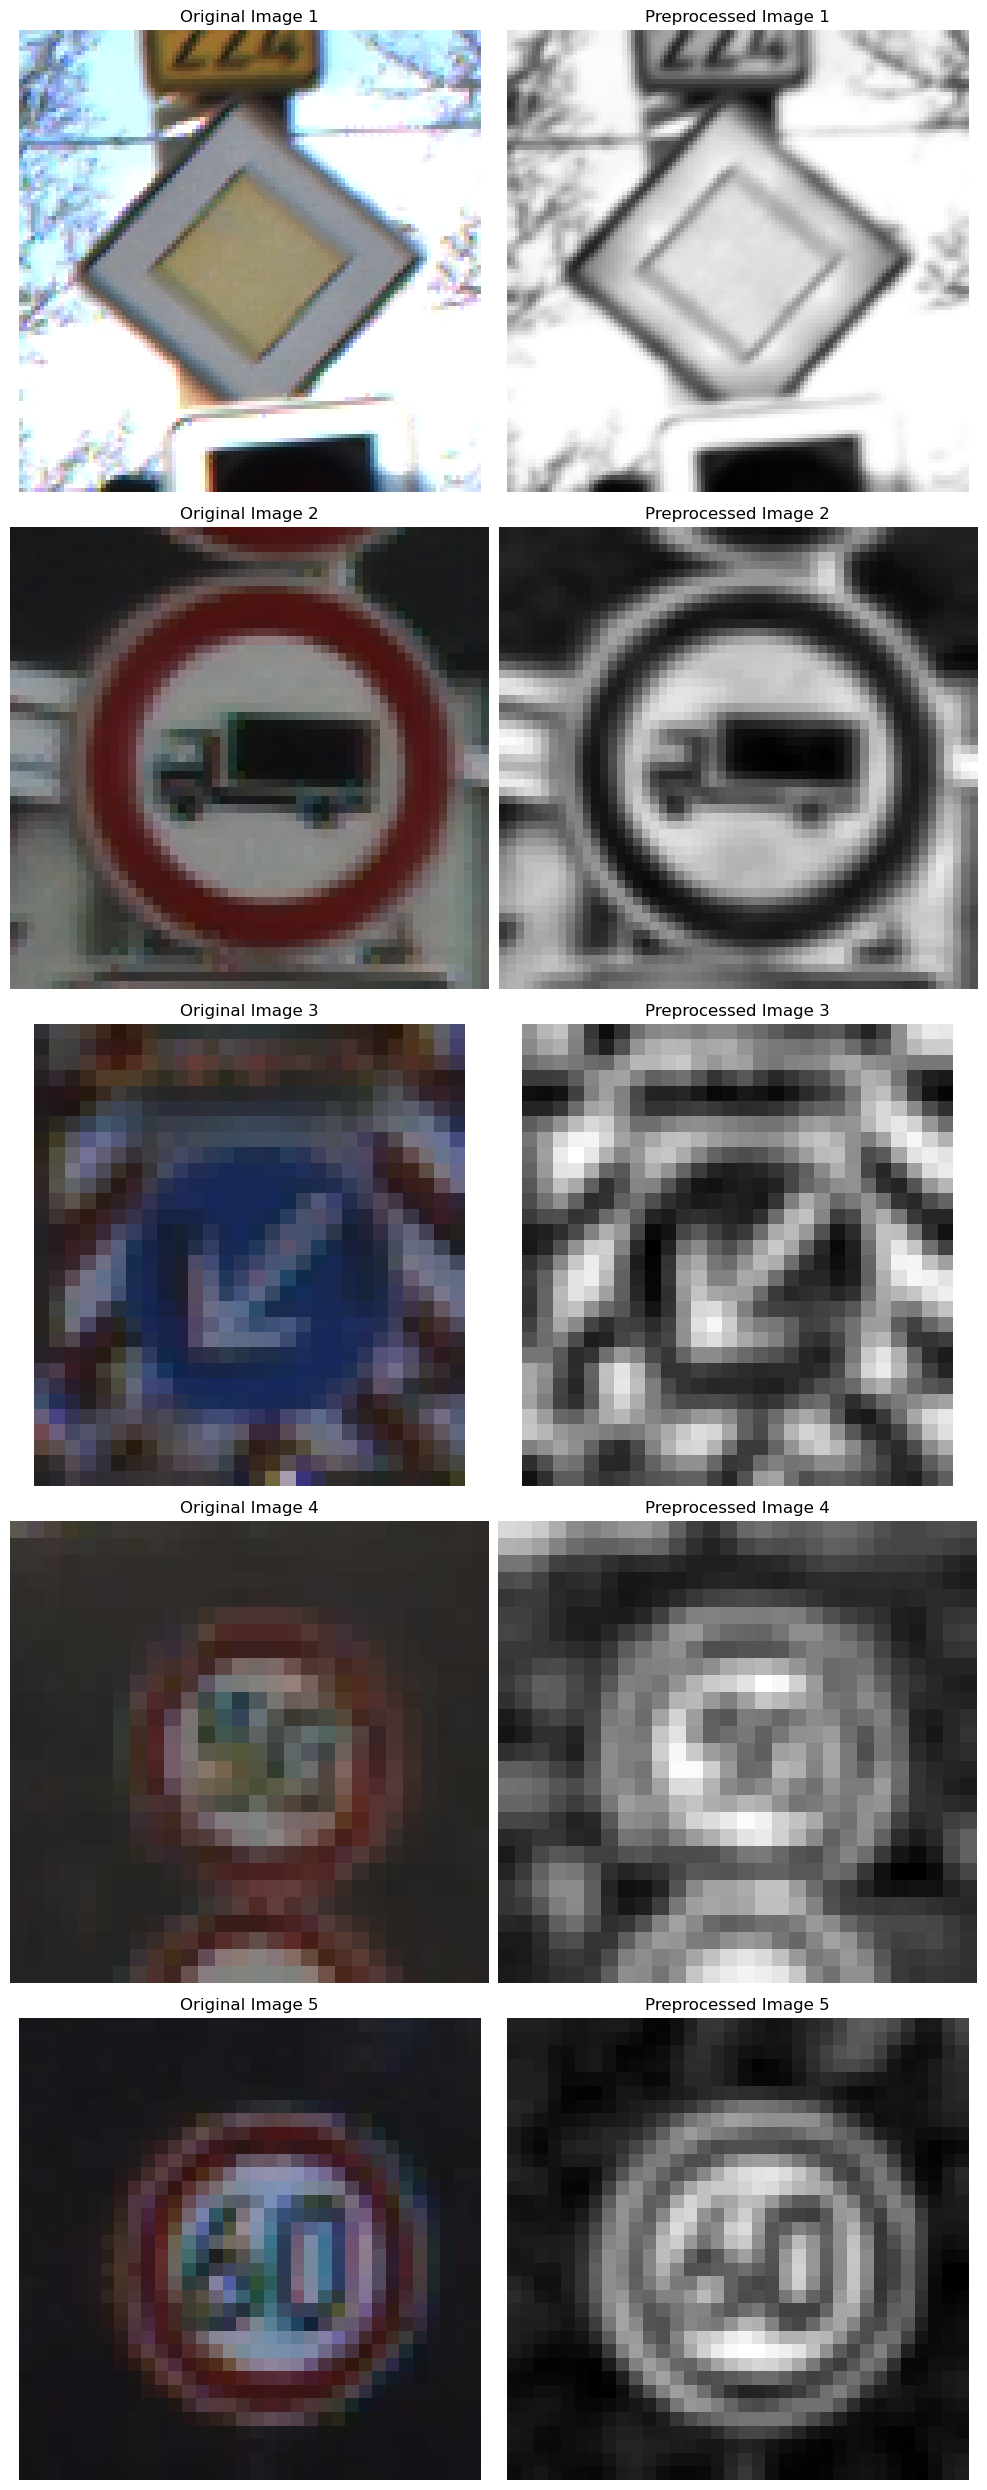

In [10]:
# Converts images to greyscale, enhances contrast and corrects brightness
def preprocess_images_shape(train_images):
    processed = []
    for image in train_images:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE to correct contrasts
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(enhanced, (3,3), 0)
        processed.append(blurred)

    return processed

shape_preprocessed = preprocess_images_shape(train_images)

# Plot for parameter tweaking


def plot_preprocessed_images(original_images, preprocessed_images, num_images=5):
    num_images = min(num_images, len(original_images))
    plt.figure(figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Plot preprocessed image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(preprocessed_images[i], cmap='gray')
        plt.title(f"Preprocessed Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the original and preprocessed images
plot_preprocessed_images(train_images, shape_preprocessed, num_images=5)



### Find shapes of main features

First Extract Contours

In [11]:
# Apply grayscale, blur and edge detection to find contours
def isolate_contours(processed_images):
    contours_dict = {}
    for index, image in enumerate(processed_images):
        # Apply Canny edge detection
        edges = cv2.Canny(image, 170, 300)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contours_dict[index] = contours


    return contours_dict

# Extract contours
contours_dict = isolate_contours(shape_preprocessed)

# Get contour solidity, aspect ratio and extent for the largest contour in each image
# Code adapted from https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html

def get_contour_properties(contours_dict):
    properties_list = []
    for img_idx, contours in contours_dict.items():
        # Find largest contour and get its properties
        if not contours:
            properties_list.append({
            'solidity': 0,
            'aspect_ratio': 0,
            'extent': 0
            })
            
            continue    

        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)

        # Solidity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0

        # Aspect ratio
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h if h > 0 else 0

        # Extent
        rect_area = w * h
        extent = float(area)/rect_area if rect_area > 0 else 0

        # Store properties  in a dictionary
        properties_list.append({
            'solidity': solidity,
            'aspect_ratio': aspect_ratio,
            'extent': extent
        })

    return properties_list




#### Find contour properties and add to the dataframe

In [12]:
# Find contour properties and add to the dataframe
contour_properties = get_contour_properties(contours_dict)
contour_df = pd.DataFrame(contour_properties)

# Add contour properties to the train_df
train_df = pd.concat([train_df, contour_df], axis = 1)




In [13]:
train_df.head()

,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,id,ClassId,solidity,aspect_ratio,extent
0,img_005489.jpg,0.215820,185.704590,185.033691,179.084717,0.0,0.043099,0.018964,0.031606,0.056316,...,-0.301160,-0.334299,0.138616,0.257037,0.684263,661,NaN,0.034660,1.085714,0.017763
1,img_005490.jpg,0.174561,67.885010,69.434814,81.814453,0.0,0.046065,0.411173,0.651735,0.175730,...,0.829642,0.137557,0.487105,-0.306732,-0.213233,4477,NaN,0.961220,1.090909,0.686553
2,img_005491.jpg,0.068115,72.898193,56.364990,56.273926,0.0,0.006825,0.040948,0.170616,0.316492,...,0.182572,-0.373714,0.262148,0.122967,-0.624942,1046,NaN,0.167671,1.037037,0.110450
3,img_005492.jpg,0.039551,47.619629,50.394043,59.411377,0.0,0.000000,0.000000,0.021120,0.815159,...,0.411835,-0.654511,0.084131,-0.269949,-0.186074,631,NaN,0.355556,0.833333,0.266667
4,img_005493.jpg,0.073242,46.095947,39.547852,44.725586,0.0,0.000000,0.299374,0.917305,0.168114,...,-0.020706,0.609833,0.413756,-0.373302,0.257994,6533,NaN,0.972644,0.961538,0.738462


In [14]:
import cv2
import matplotlib.pyplot as plt

def plot_contours(train_images, contours_list):
    """
    Plots the contours on the original images.

    Parameters:
        train_images (list): List of original images.
        contours_list (list): List of contours for each image.
    """
    for i, (image, contours) in enumerate(zip(train_images, contours_list)):
        # Create a copy of the image to draw contours
        image_with_contours = image.copy()

        # Draw contours on the image
        cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

        # Convert BGR to RGB for plotting
        image_with_contours = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

        # Plot the image with contours
        plt.figure(figsize=(6, 6))
        plt.title(f"Image {i+1} with Contours")
        plt.imshow(image_with_contours)
        plt.axis('off')
        plt.show()



### Plot contours
# plot_contours(train_images, contours_dict.values())

### Hu moments

In [15]:
# Weighted moment of the image pixel's, good for shape recognition for possibly distorted images


def calculate_hu_moments(images):
    """Takes preprocessed images and returns Hu moments"""
    hu_moments_list = []
    for image in images:
        # Calculate moments
        moments = cv2.moments(image)

        # Calculate Hu moments
        hu_moments = cv2.HuMoments(moments).flatten()

        # Log-transform Hu Moments (normalise)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        hu_moments_list.append(hu_moments)

    return hu_moments_list


# Use our shape preprocessed images
hu_moments_list = calculate_hu_moments(shape_preprocessed)


# Save Hu moments to train_df (7 Hu moments = 7 columns)
# Convert Hu moments list to a DataFrame
hu_moments_df = pd.DataFrame(hu_moments_list, columns=[f"Hu_{i+1}" for i in range(7)])

# Ensure the number of rows matches between train_df and hu_moments_df
assert len(train_df) == len(hu_moments_df), "Mismatch in number of rows between train_df and Hu moments."

# Concatenate Hu moments with train_df
train_df = pd.concat([train_df, hu_moments_df], axis=1)


train_df.head()


,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,solidity,aspect_ratio,extent,Hu_1,Hu_2,Hu_3,Hu_4,Hu_5,Hu_6,Hu_7
0,img_005489.jpg,0.215820,185.704590,185.033691,179.084717,0.0,0.043099,0.018964,0.031606,0.056316,...,0.034660,1.085714,0.017763,3.078830,8.345914,9.990838,9.998820,-10.0,-10.000000,10.0
1,img_005490.jpg,0.174561,67.885010,69.434814,81.814453,0.0,0.046065,0.411173,0.651735,0.175730,...,0.961220,1.090909,0.686553,2.817139,7.643986,9.637134,9.999730,-10.0,-10.000000,-10.0
2,img_005491.jpg,0.068115,72.898193,56.364990,56.273926,0.0,0.006825,0.040948,0.170616,0.316492,...,0.167671,1.037037,0.110450,2.859425,8.286721,9.993703,9.999841,-10.0,-10.000000,-10.0
3,img_005492.jpg,0.039551,47.619629,50.394043,59.411377,0.0,0.000000,0.000000,0.021120,0.815159,...,0.355556,0.833333,0.266667,2.831035,8.293184,9.951288,9.959348,-10.0,9.999997,-10.0
4,img_005493.jpg,0.073242,46.095947,39.547852,44.725586,0.0,0.000000,0.299374,0.917305,0.168114,...,0.972644,0.961538,0.738462,2.818877,8.506218,9.968181,9.968373,-10.0,-9.999999,-10.0


In [16]:
# Save Hu moments to train_df (7 Hu moments = 7 columns)
# Convert Hu moments list to a DataFrame
hu_moments_df = pd.DataFrame(hu_moments_list, columns=[f"Hu_{i+1}" for i in range(7)])

# Ensure the number of rows matches between train_df and hu_moments_df
assert len(train_df) == len(hu_moments_df), "Mismatch in number of rows between train_df and Hu moments."

# Concatenate Hu moments with train_df
train_df = pd.concat([train_df, hu_moments_df], axis=1)

### Edge orientation histogram

In [17]:
def get_edge_orientation_histograms(images, num_bins):
    """ Compute edge orientation histograms for a list of images.
        uses the orientation of the pixel gradients to create a histogram"""

    hist_list = []
    for image in images:
        mask = get_center_mask(image, radius_ratio=0.4)

        # Compute gradients in x and y directions
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Compute gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        # Compute direction in degrees
        angle = np.arctan2(grad_y, grad_x) * 180 / np.pi

        # Normalize to 0-180 degree range
        angle = (angle + 180) % 180

        if mask is not None:
            mask_bool = mask > 0
            magnitude = magnitude[mask_bool]
            angle = angle[mask_bool]

        else:
            magnitude = magnitude.flatten()
            angle = angle.flatten()

        # Create histogram weighted by magnitude
        hist, _ = np.histogram(angle, bins=num_bins, range=(0, 180), weights=magnitude)

        # Normalize histogram
        hist = hist / (np.sum(hist) + 1e-6)

        # Add to the list
        hist_list.append(hist)

    return hist_list

# Mask to isolate the center of the image
def get_center_mask(image, radius_ratio):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    radius = int(min(h, w) * radius_ratio)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    return mask



In [18]:
# Get edge orientation histograms
num_bins = 8
edge_orientation_histograms = get_edge_orientation_histograms(shape_preprocessed, num_bins=num_bins)

# Convert to df
edge_hist_columns = [f"Edge_Hist_Bin_{i+1}" for i in range(num_bins)]
edge_hist_df = pd.DataFrame(edge_orientation_histograms, columns=edge_hist_columns)

# Concatenate the edge histograms with train_df
train_df = pd.concat([train_df, edge_hist_df], axis=1)

train_df.head()


,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,Hu_6,Hu_7,Edge_Hist_Bin_1,Edge_Hist_Bin_2,Edge_Hist_Bin_3,Edge_Hist_Bin_4,Edge_Hist_Bin_5,Edge_Hist_Bin_6,Edge_Hist_Bin_7,Edge_Hist_Bin_8
0,img_005489.jpg,0.215820,185.704590,185.033691,179.084717,0.0,0.043099,0.018964,0.031606,0.056316,...,-10.000000,10.0,0.052263,0.297684,0.118756,0.110545,0.050912,0.228966,0.096909,0.043966
1,img_005490.jpg,0.174561,67.885010,69.434814,81.814453,0.0,0.046065,0.411173,0.651735,0.175730,...,-10.000000,-10.0,0.100273,0.093234,0.136648,0.136888,0.197745,0.130641,0.109013,0.095557
2,img_005491.jpg,0.068115,72.898193,56.364990,56.273926,0.0,0.006825,0.040948,0.170616,0.316492,...,-10.000000,-10.0,0.149954,0.138703,0.165240,0.153416,0.119123,0.099810,0.056312,0.117442
3,img_005492.jpg,0.039551,47.619629,50.394043,59.411377,0.0,0.000000,0.000000,0.021120,0.815159,...,9.999997,-10.0,0.095044,0.120275,0.095331,0.188846,0.188937,0.102645,0.083364,0.125558
4,img_005493.jpg,0.073242,46.095947,39.547852,44.725586,0.0,0.000000,0.299374,0.917305,0.168114,...,-9.999999,-10.0,0.148215,0.103215,0.113630,0.173698,0.156445,0.100943,0.095254,0.108601


## Colour feature extraction

### HSV Histogram + mean and variation

In [19]:
# Separates color from intensity so good for low light color features

# Extract HSV features from images
def extract_hsv_features(images, bins = 16):

    hsv_features_list = []

    for image in images:
        mask = get_center_mask(image, radius_ratio=0.4)

        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)

        # Mean and std var for each channel
        hsv_features = [
            np.mean(h), np.std(h),
            np.mean(s), np.std(s),
            np.mean(v), np.std(v)
        ]

        # Add HSV histogram

        for channel, rng in zip([h, s, v], [(0,180), (0,256), (0,256)]):
            hist = cv2.calcHist([channel], [0], mask, [bins], rng)
            hist = hist.flatten()
            hist = hist / (hist.sum() + 1e-6)
            hsv_features.extend(hist)
        hsv_features_list.append(hsv_features)

    return np.array(hsv_features_list)






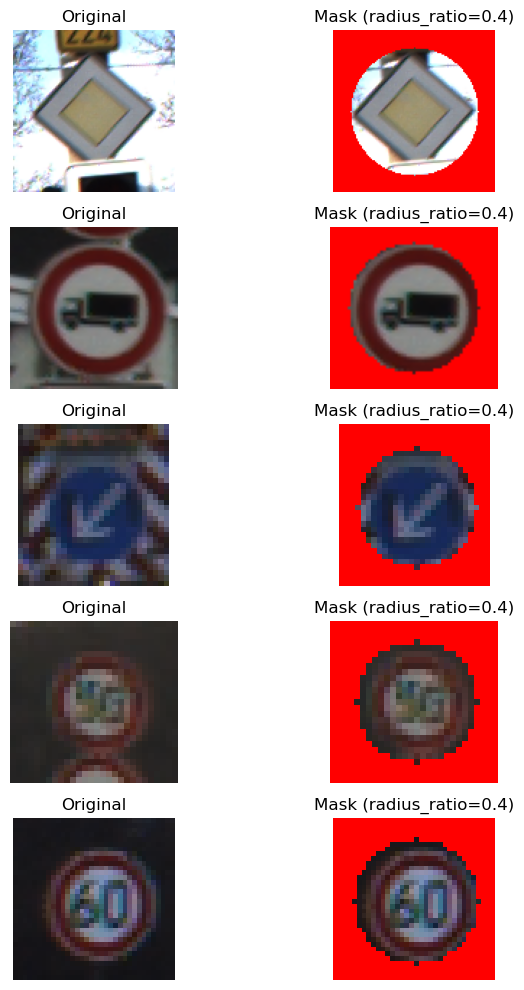

In [20]:
import matplotlib.pyplot as plt

def show_center_mask_samples(images, radius_ratio=0.4, num_samples=5):
    plt.figure(figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        img = images[i]
        mask = get_center_mask(img, radius_ratio=radius_ratio)
        # Overlay mask on image (red mask)
        overlay = img.copy()
        overlay[mask == 0] = [0, 0, 255]  # Red where mask is zero

        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Mask (radius_ratio={radius_ratio})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_center_mask_samples(train_images, radius_ratio=0.4, num_samples=5)

In [21]:
# Extract HSV features
hsv_features = extract_hsv_features(train_images, bins = 16)
print(hsv_features.shape)

# For 32 bins
columns = [f"{channel}_mean" for channel in ['H', 'S', 'V']] + \
          [f"{channel}_std" for channel in ['H', 'S', 'V']] + \
          [f"{channel}_hist_bin_{i+1}" for channel in ['H', 'S', 'V'] for i in range(16)]


# Convert HSV features to DataFrame
hsv_features_df = pd.DataFrame(hsv_features, columns=columns)

# Add to train_df
train_df = pd.concat([train_df, hsv_features_df], axis=1)


(2353, 54)


In [22]:
train_df.head()

,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,V_hist_bin_7,V_hist_bin_8,V_hist_bin_9,V_hist_bin_10,V_hist_bin_11,V_hist_bin_12,V_hist_bin_13,V_hist_bin_14,V_hist_bin_15,V_hist_bin_16
0,img_005489.jpg,0.215820,185.704590,185.033691,179.084717,0.0,0.043099,0.018964,0.031606,0.056316,...,0.028797,0.043113,0.078986,0.329439,0.083594,0.017114,0.013987,0.014316,0.015468,0.29949
1,img_005490.jpg,0.174561,67.885010,69.434814,81.814453,0.0,0.046065,0.411173,0.651735,0.175730,...,0.098220,0.058668,0.226104,0.030982,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,img_005491.jpg,0.068115,72.898193,56.364990,56.273926,0.0,0.006825,0.040948,0.170616,0.316492,...,0.103448,0.076923,0.047745,0.002653,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,img_005492.jpg,0.039551,47.619629,50.394043,59.411377,0.0,0.000000,0.000000,0.021120,0.815159,...,0.078864,0.088328,0.022082,0.003155,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,img_005493.jpg,0.073242,46.095947,39.547852,44.725586,0.0,0.000000,0.299374,0.917305,0.168114,...,0.073724,0.056711,0.034026,0.058601,0.051040,0.007561,0.000000,0.000000,0.000000,0.00000


## Save the final dataframe

In [23]:
# Output train_df to csv
file_path = 'data/test/features/all_features.csv'
train_df.to_csv(file_path, index=False)
